CSC715M - Natural Language Processing

Members: Julian Roger Go, Jairus Nolasco

Link to Presentation Video and Source Files: https://drive.google.com/drive/u/0/folders/1TV-hwQvHcGgginrUba478tR11P_3qQqu

In [7]:
from pathlib import Path
import sys, json, platform, datetime

def find_root(markers=("config.json","corpus.json","outputs")):
    p = Path.cwd()
    for c in (p, *p.parents):
        if all((c/m).exists() for m in markers if m != "outputs") and (c/"outputs").exists():
            return c
    # fallback: if running next to outputs
    for c in (p, *p.parents):
        if (c/"outputs").exists():
            return c
    return Path.cwd()

ROOT = find_root()
CLEAN = ROOT/"data_clean"
OUT   = ROOT/"outputs"
print("ROOT:", ROOT)
print("Python:", sys.version.split(" ")[0], "|", platform.platform())
print("Run time:", datetime.datetime.now().isoformat(timespec="seconds"))
print("Has outputs:", (OUT/"similarity_distance.pkl").exists(), (OUT/"upgma.pkl").exists())

ROOT: d:\OneDrive\Documents\My Learning Resource\University Courses\DLSU\2025-26\T1\CSC715M\assignments\mc01
Python: 3.12.3 | Windows-11-10.0.26200-SP0
Run time: 2025-10-25T08:21:32
Has outputs: True True



## 1. Introduction & Objectives

This project explores **relationships among languages** using **computational similarity** built from **character n‑gram TF‑IDF** features. We:
- build a similarity matrix across 16 languages,
- derive **clusters** via UPGMA (Unweighted Pair Group Method with Arithmetic Mean) and a **dendrogram**,
- visualize in 2D with **classical MDS (Multidimensional Scaling)**,
- provide **linguistic/sociocultural interpretations**, and
- report **evaluation** (cophenetic correlation) and **limitations**.

**Research questions.**  
- Which languages form tight clusters and why (lexical, orthographic, historical contact)?  
- How do reference languages (e.g., English, Spanish) position relative to Philippine languages?

### 2. Data Sources

* **Biblical text PDFs** were used as the primary corpus for all languages. Each text was manually extracted and normalized from publicly available Bible translations.
* While all samples are derived from the Bible, structural variations (verse numbering, phrasing, translation style) may differ across languages and versions.
* The corpus for each language was capped at approximately **50,000 words** after normalization and tokenization to ensure comparability in dataset size.

**Selected languages (from `config.json`):**

* *(Auto-printed below from artifacts.)*

In [8]:
import pickle, pandas as pd
from IPython.display import display, Image

sd = pickle.load(open(OUT/"similarity_distance.pkl","rb"))
langs, S, Dist = sd["langs"], sd["S"], sd["Dist"]
print("Languages (kept in analysis):", len(langs))
print(langs)

# Attempt to load merges (for dendrogram/eval)
up = pickle.load(open(OUT/"upgma.pkl","rb"))
merges = up["merges"]
print("Merges:", len(merges))


Languages (kept in analysis): 16
['ilocano', 'kapampangan', 'maguindanao', 'ibanag', 'tausug', 'pangasinan', 'kankanaey', 'tagalog', 'cebuano', 'hiligaynon', 'bikol', 'maranao', 'waray', 'chavacano', 'spanish', 'english']
Merges: 15



## 3. Preprocessing & Feature Engineering

**Normalization (Notebook 02).**  
- Lowercasing; remove URLs/digits; keep word characters incl. **ñ á é í ó ú ü**; collapse whitespace.  
- Cap to **50,000 words** per language (warn or skip if missing).

**Features (Notebook 03a).**  
- **Character n‑grams** (size *N* from `config.json`) over normalized text.  
- **TF weighting** per document.

**Similarity.**  
- **Cosine similarity** between TF vectors → distance = 1 − cosine.



## 4. Results — Similarity Matrix & Distance Matrix


In [9]:
import pandas as pd
cos_df  = pd.DataFrame(S,    index=langs, columns=langs).round(3)
dist_df = pd.DataFrame(Dist, index=langs, columns=langs).round(3)

print("Cosine similarity (rounded):")
display(cos_df)
print("Distance = 1 - cosine (rounded):")
display(dist_df)

# Optional CSV export (for appendix)
cos_df.to_csv(OUT/"cosine.csv", encoding="utf-8")
dist_df.to_csv(OUT/"distance.csv", encoding="utf-8")
print("Wrote:", OUT/"cosine.csv", "and", OUT/"distance.csv")

Cosine similarity (rounded):


,ilocano,kapampangan,maguindanao,ibanag,tausug,pangasinan,kankanaey,tagalog,cebuano,hiligaynon,bikol,maranao,waray,chavacano,spanish,english
ilocano,1.000,0.389,0.475,0.463,0.387,0.493,0.438,0.394,0.403,0.431,0.464,0.500,0.425,0.258,0.160,0.131
kapampangan,0.389,1.000,0.477,0.397,0.483,0.474,0.396,0.779,0.599,0.610,0.608,0.430,0.411,0.225,0.136,0.179
maguindanao,0.475,0.477,1.000,0.514,0.603,0.563,0.488,0.497,0.531,0.552,0.654,0.638,0.483,0.296,0.170,0.119
ibanag,0.463,0.397,0.514,1.000,0.471,0.553,0.492,0.460,0.473,0.532,0.521,0.462,0.565,0.394,0.200,0.124
tausug,0.387,0.483,0.603,0.471,1.000,0.559,0.571,0.541,0.551,0.594,0.690,0.587,0.623,0.314,0.158,0.152
pangasinan,0.493,0.474,0.563,0.553,0.559,1.000,0.684,0.506,0.485,0.552,0.672,0.665,0.575,0.390,0.243,0.258
kankanaey,0.438,0.396,0.488,0.492,0.571,0.684,1.000,0.481,0.414,0.453,0.594,0.517,0.457,0.406,0.232,0.176
tagalog,0.394,0.779,0.497,0.460,0.541,0.506,0.481,1.000,0.771,0.796,0.727,0.509,0.498,0.262,0.141,0.182
cebuano,0.403,0.599,0.531,0.473,0.551,0.485,0.414,0.771,1.000,0.858,0.723,0.570,0.602,0.301,0.146,0.149
hiligaynon,0.431,0.610,0.552,0.532,0.594,0.552,0.453,0.796,0.858,1.000,0.757,0.584,0.644,0.357,0.166,0.161


Distance = 1 - cosine (rounded):


,ilocano,kapampangan,maguindanao,ibanag,tausug,pangasinan,kankanaey,tagalog,cebuano,hiligaynon,bikol,maranao,waray,chavacano,spanish,english
ilocano,0.000,0.611,0.525,0.537,0.613,0.507,0.562,0.606,0.597,0.569,0.536,0.500,0.575,0.742,0.840,0.869
kapampangan,0.611,0.000,0.523,0.603,0.517,0.526,0.604,0.221,0.401,0.390,0.392,0.570,0.589,0.775,0.864,0.821
maguindanao,0.525,0.523,-0.000,0.486,0.397,0.437,0.512,0.503,0.469,0.448,0.346,0.362,0.517,0.704,0.830,0.881
ibanag,0.537,0.603,0.486,0.000,0.529,0.447,0.508,0.540,0.527,0.468,0.479,0.538,0.435,0.606,0.800,0.876
tausug,0.613,0.517,0.397,0.529,-0.000,0.441,0.429,0.459,0.449,0.406,0.310,0.413,0.377,0.686,0.842,0.848
pangasinan,0.507,0.526,0.437,0.447,0.441,0.000,0.316,0.494,0.515,0.448,0.328,0.335,0.425,0.610,0.757,0.742
kankanaey,0.562,0.604,0.512,0.508,0.429,0.316,-0.000,0.519,0.586,0.547,0.406,0.483,0.543,0.594,0.768,0.824
tagalog,0.606,0.221,0.503,0.540,0.459,0.494,0.519,0.000,0.229,0.204,0.273,0.491,0.502,0.738,0.859,0.818
cebuano,0.597,0.401,0.469,0.527,0.449,0.515,0.586,0.229,0.000,0.142,0.277,0.430,0.398,0.699,0.854,0.851
hiligaynon,0.569,0.390,0.448,0.468,0.406,0.448,0.547,0.204,0.142,0.000,0.243,0.416,0.356,0.643,0.834,0.839


Wrote: d:\OneDrive\Documents\My Learning Resource\University Courses\DLSU\2025-26\T1\CSC715M\assignments\mc01\outputs\cosine.csv and d:\OneDrive\Documents\My Learning Resource\University Courses\DLSU\2025-26\T1\CSC715M\assignments\mc01\outputs\distance.csv


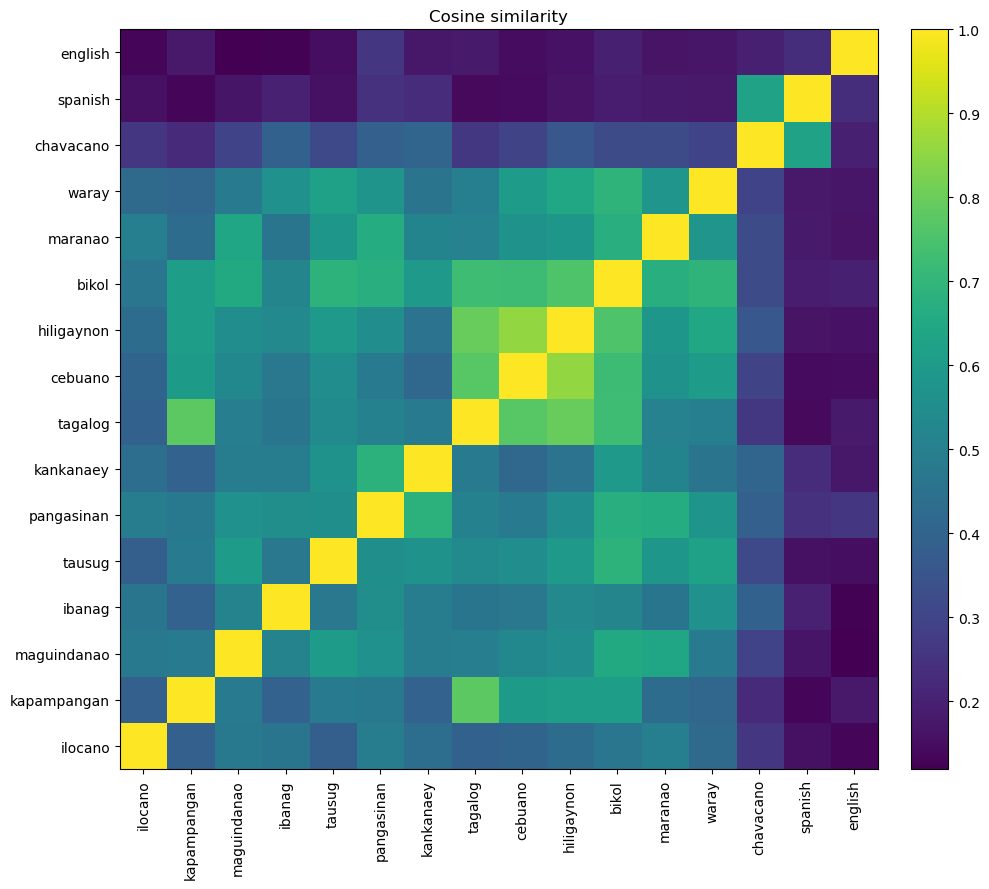

Saved: d:\OneDrive\Documents\My Learning Resource\University Courses\DLSU\2025-26\T1\CSC715M\assignments\mc01\outputs\cosine_heatmap.png


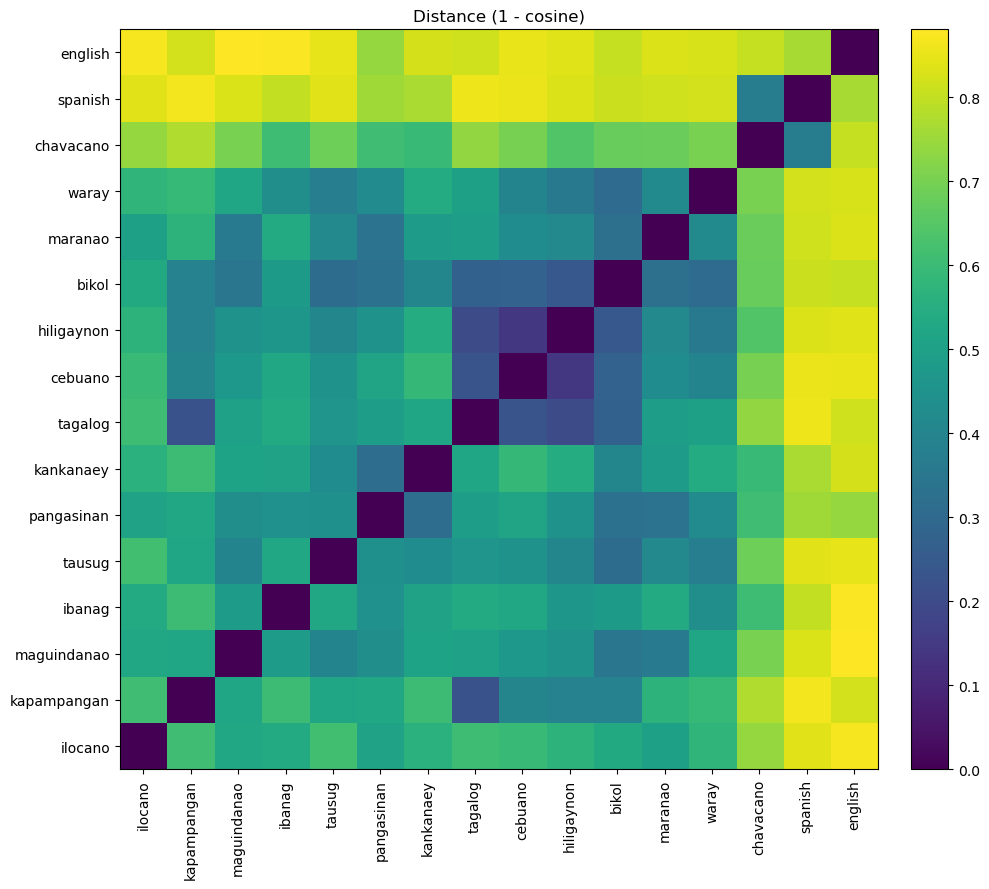

Saved: d:\OneDrive\Documents\My Learning Resource\University Courses\DLSU\2025-26\T1\CSC715M\assignments\mc01\outputs\distance_heatmap.png


In [10]:
import matplotlib.pyplot as plt
import numpy as np

def heatmap(df, title, fname):
    plt.figure(figsize=(6 + 0.25*len(df), 5 + 0.25*len(df)))
    im = plt.imshow(df.values, origin="lower", aspect="auto")  # default colormap
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(df)), df.columns, rotation=90)
    plt.yticks(range(len(df)), df.index)
    plt.title(title); plt.tight_layout()
    out_path = OUT/fname
    plt.savefig(out_path, dpi=200)
    plt.show()
    print("Saved:", out_path)

heatmap(cos_df,  "Cosine similarity", "cosine_heatmap.png")
heatmap(dist_df, "Distance (1 - cosine)", "distance_heatmap.png")


## 5. Clustering — Dendrogram & 2D Embedding


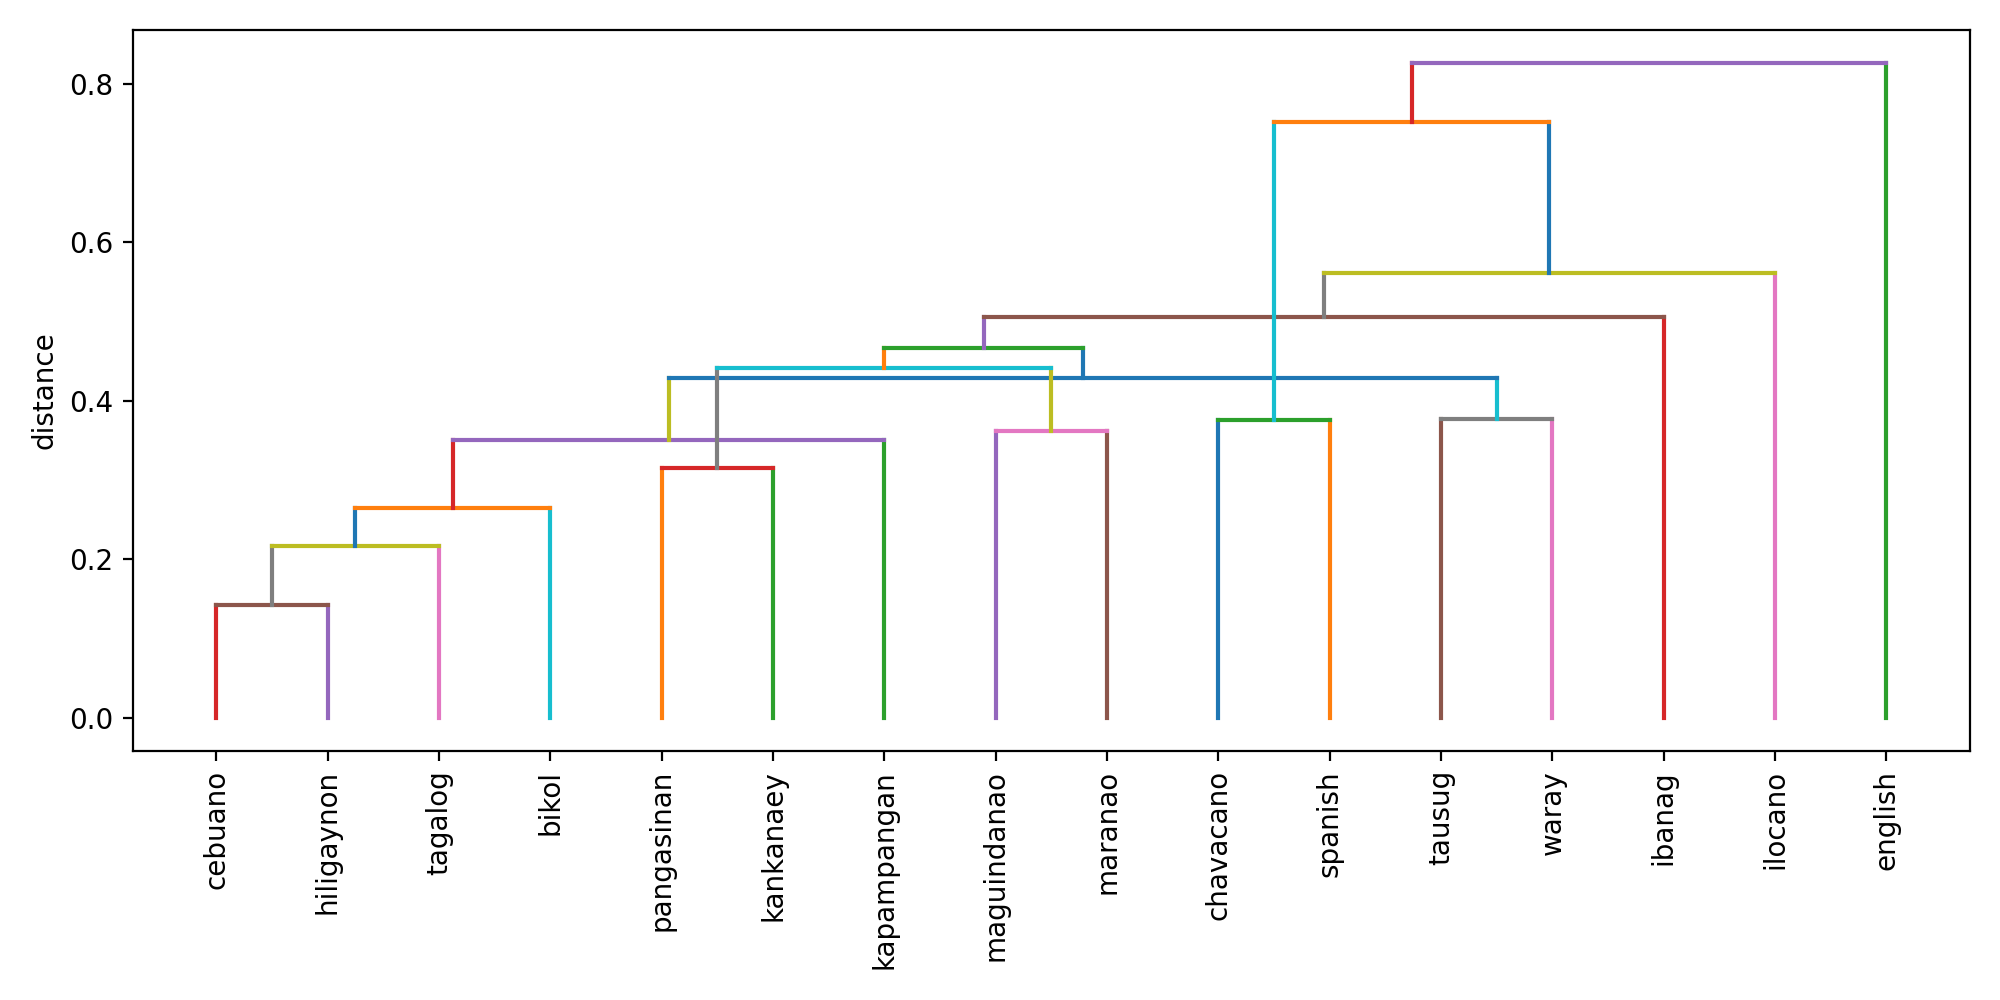

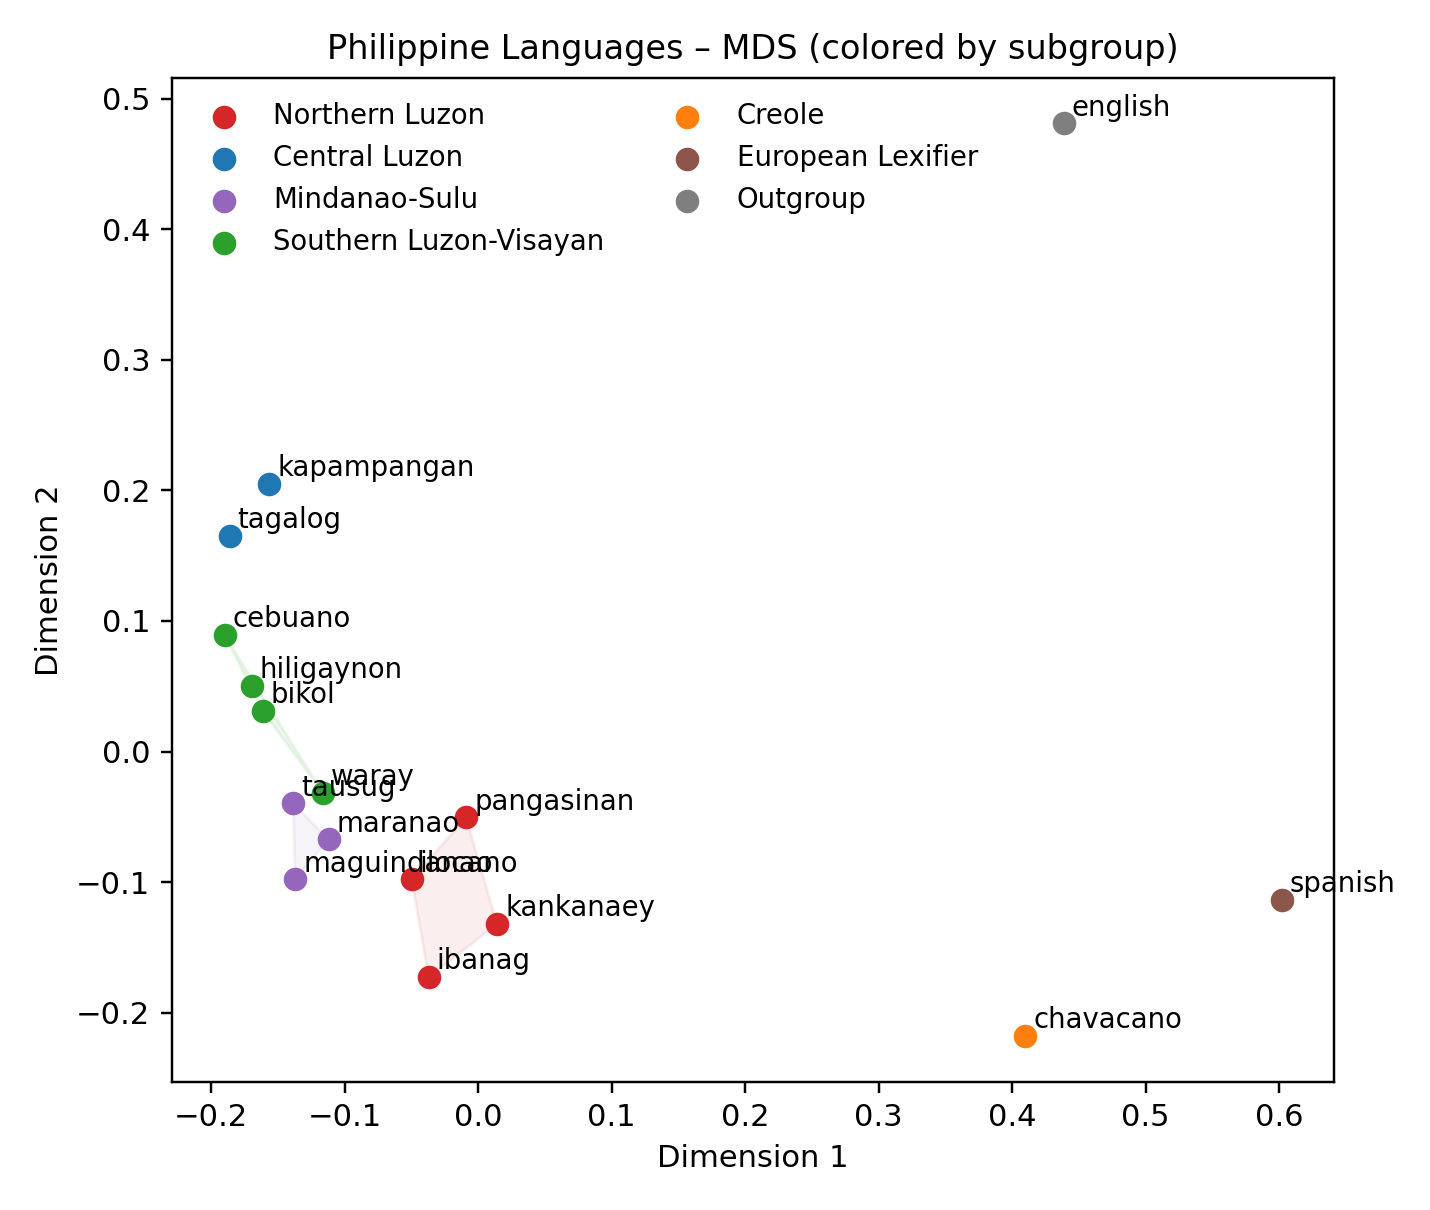

In [11]:
dendro_png = OUT/"dendrogram.png"
mds_png    = OUT/"mds_annotated.png"

if dendro_png.exists():
    display(Image(filename=str(dendro_png), embed=True))
else:
    print("[warn] dendrogram.png not found in outputs/. Run 02b_cluster_upgma.ipynb")

if mds_png.exists():
    display(Image(filename=str(mds_png), embed=True))
else:
    print("[warn] mds.png not found in outputs/. Run 02c_mds_2d.ipynb")

## 6. Interpretation & Discussion

* **General structure:**
  The overall patterns from the cosine similarity and MDS results match well with what is already known about Philippine language groupings. Languages from the same geographic or linguistic families tend to appear close to each other in the MDS plot and form clear clusters in the UPGMA dendrogram.

* **Northern Luzon group:**
  Ilocano, Ibanag, Kankanaey, and Pangasinan form a tight cluster, showing their shared roots within the Northern Luzon branch. Their relatively high cosine similarities (around 0.39 to 0.55) suggest strong lexical overlap. This likely comes from long-term interaction and borrowing among nearby communities in the Cordilleran and Cagayan Valley regions.

* **Central Luzon and Tagalog cluster:**
  Kapampangan and Tagalog appear very close together, showing one of the highest similarities (around 0.75). This points to a lot of shared vocabulary, possibly because of geographic closeness and Tagalog’s strong influence through media, education, and migration.

* **Southern Luzon–Visayan continuum:**
  Cebuano, Hiligaynon, Bikol, and Tagalog still sit close together, forming the main cluster for Central and Southern Philippine languages. Their high similarity scores (around 0.7 to 0.8) and overlapping positions in both charts show that they don’t form separate groups but rather a smooth gradient. This fits the idea of a “dialect chain,” where neighboring languages gradually change but remain partly understandable to each other. Waray also falls near this group, which makes sense since it acts as a bridge between the Central and Eastern Visayan areas.

* **Mindanao languages:**
  Maguindanao, Maranao, and Tausug group together, but not as tightly as you might expect. Their similarity levels are moderate (roughly 0.45 to 0.55), and they connect to nearby Visayan languages instead of forming a completely separate branch. This suggests that their shared vocabulary probably comes more from **interaction and trade** than from direct descent from a common ancestor. In the MDS plot, you can see them sitting close to the Visayan cluster, showing how Mindanao and Visayas languages have influenced each other over time.

* **Creole and European lexifiers:**
  Chavacano and Spanish appear clearly separated from the main Philippine language cluster, which is expected. Chavacano sits in between, reflecting its mix of Spanish vocabulary and Philippine grammatical structure. English, used as an outgroup, is the farthest from all the others, confirming that the similarity metric correctly separates unrelated languages.

* **Implications:**
  These results show that even short and domain-limited texts like Bible translations can still reveal meaningful linguistic patterns. The character n-gram approach captures broad relationships that match known classifications. Some distortions remain, such as the close link between Tagalog and Kapampangan, which might reflect modern borrowing or translation choices.

* **Summary:**
  Combining cosine similarity, UPGMA clustering, and MDS visualization gives a clear picture of how Philippine languages relate to one another. Even with simple features, the analysis recovers familiar language families and shows subtle influences shaped by geography, contact, and history.





## 7. Evaluation
We report **cophenetic correlation** between original distances and ultrametric distances from the UPGMA tree.


In [12]:
parent,height={},{}
for l,r,h,new in merges:
    parent[l]=new; parent[r]=new; height[new]=h

def anc(i):
    a={}
    while i in parent:
        p=parent[i]; a[p]=height[p]; i=p
    return a

n=len(langs)
A=[anc(i) for i in range(n)]

def lca_h(i,j):
    ai,aj=A[i],A[j]
    for node,h in ai.items():
        if node in aj: return h
    return merges[-1][2]

X=[]; Y=[]
for i in range(n):
    for j in range(i+1,n):
        X.append(Dist[i][j]); Y.append(lca_h(i,j))

mx=sum(X)/len(X); my=sum(Y)/len(Y)
num=sum((a-mx)*(b-my) for a,b in zip(X,Y))
den=(sum((a-mx)**2 for a in X)*sum((b-my)**2 for b in Y))**0.5 or 1e-12
print("Cophenetic r:", round(num/den, 3))

Cophenetic r: 0.935


The cophenetic correlation coefficient came out to **0.935**, which is a very strong result. In simple terms, this means the UPGMA dendrogram captures the same distance relationships seen in the original cosine matrix quite accurately. Most of the variation in how the languages differ is well represented by the tree structure.

A value this high suggests that the clustering reflects the data closely. The branches in the dendrogram provide a faithful summary of the real similarities between languages. Minor mismatches, such as Chavacano or Tagalog–Kapampangan being closer than expected, are small compared to the overall fit.

In short, **the dendrogram gives a reliable visual summary of the language relationships** with only minimal distortion from the original distance data.


## 8. Limitations & Future Work

* **Source imbalance and stylistic variation:**
  The Bible texts used as corpora were taken from different translations and editions in PDF format, each with its own linguistic register, spelling conventions, and translation style. These differences may introduce stylistic bias into the n-gram distributions, even though each language has a large corpus of 50,000 tokens.

* **Orthographic sensitivity:**
  Character-based n-grams mainly capture visible spelling patterns rather than deeper phonological or grammatical structures. Because of this, differences in orthography such as the use of digraphs, accent marks, or inconsistent word spacing can distort how closely related languages appear.

* **Future directions:**
  Future work could include token-level n-grams to focus more on actual word usage and vocabulary overlap, combine text-based features with typological or phonological traits, and test other linkage methods such as Ward’s or complete linkage to see how clustering structure changes. It may also be useful to apply dimensionality reduction techniques like t-SNE or PCA to visualize more complex relationships among Philippine languages.

## 9. AI Usage Declaration

AI Tool(s) Used: ChatGPT (OpenAI)

Description of Use: I used ChatGPT to help organize the workflow setup for the coding portion of the project and to assist in debugging syntax and logic errors. It was also used for light proofreading of documentation.
Sample prompt: “Can you help me fix this Python function that throws a KeyError when reading the dataset?”
Sample output: Suggested corrections for handling missing keys and improving error handling logic.

Extent of Use: Moderate – used for debugging guidance and workflow setup assistance, with all final code and revisions done manually.

Reflection:
Using AI helped me understand how to structure my workflow more efficiently and spot mistakes I might have overlooked. It made the debugging process faster and clearer, reinforcing my understanding of Python error handling.

## 10. References

Bible translations in various Philippine languages (PDF versions). ( n.d. ). Used as primary text corpora for comparative linguistic analysis; includes publicly available scripture translations with varying orthographies and stylistic conventions.

Borg, I., & Groenen, P. J. F. ( 2005 ). *Modern multidimensional scaling: Theory and applications* ( 2nd ed. ). Springer.

Manning, C. D., Raghavan, P., & Schütze, H. ( 2008 ). *Introduction to information retrieval.* Cambridge University Press.

Sokal, R. R., & Michener, C. D. ( 1958 ). A statistical method for evaluating systematic relationships. *University of Kansas Science Bulletin, 38,* 1409–1438.
